# Lab 3: Bayesian PCA

### Machine Learning II, 2016


* The lab exercises should be made in groups of two people.
* The deadline for part 1 is Sunday, 15 May, 23:59.
* Assignment should be sent to taco.cohen at gmail dot com. The subject line of your email should be "[MLII2016] lab3part1_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[MLII2016] lab01\_Kingma\_Hu", the attached file should be "lab3part1\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!
* NOTE: please write your answers directly below the question in the notebook.

$\newcommand{\vline}{\mid}$
$\newcommand{\hline}{\dfrac{\quad}{}}$
$\newcommand{\mwtilde}[1][i]{\tilde{\vt{m}}_{\vt{w}}^{(#1)}}$
$\newcommand{\mw}[1][k]{{\vt{m}_{\vt{w}}^{(#1)}}}$
$%\newcommand{\E}[1]{\mathbb{E}\left[ #1 \right]}$
$\newcommand{\E}[1]{\left \langle #1 \right\rangle}$
$\newcommand{\EE}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\vt}[1]{\boldsymbol{\mathbf{#1}}}$
$\newcommand{\gaus}[1]{\mathcal{N}\left(#1\right)}$
$\newcommand{\lb}[0]{\left [}$
$\newcommand{\rb}[0]{\right ]}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$
$\newcommand{\la}{\left \{}$
$\newcommand{\ra}{\right \}}$

> #### By: Ysbrand Galama, 10262067
> #### Ties van Rozendaal, 10077391

### Introduction

In this lab assignment, we will implement a variational algorithm for Bayesian PCA. Unlike regular PCA based on maximization of retained variance or minimization of projection error (see Bishop, 12.1.1 and 12.1.2), probabilistic PCA defines a proper density model over observed and latent variables. We will work with a fully Bayesian model this time, which is to say that we will put priors on our parameters and will be interested in learning the posterior over those parameters. Bayesian methods are very elegant, but require a shift in mindset: we are no longer looking for a point estimate of the parameters (as in maximum likelihood or MAP), but for a full posterior distribution over the space of parameters.

The integrals involved in a Bayesian analysis are usually analytically intractable, so that we must resort to approximations. In this lab assignment, we will implement the variational method described in Bishop99. Chapters 10 and 12 of the PRML book contain additional material that may be useful when doing this exercise.

* [Bishop99] Variational Principal Components, C. Bishop, ICANN 1999 - http://research.microsoft.com/pubs/67241/bishop-vpca-icann-99.pdf

Below, you will find some code to get you started.

### 1. The Q-distribution (5 points)

In variational Bayes, we introduce a distribution $Q(\Theta)$ over parameters / latent variables in order to make inference tractable. We can think of $Q$ as being an approximation of a certain distribution. What function does $Q$ approximate, $p(D|\Theta)$, $p(\Theta|D)$, $p(D, \Theta)$, $p(\Theta)$, or $p(D)$, and how do you see that from the equation $\ln p(D) = \mathcal{L}(Q) + \mathrm{KL}(Q||P)$? (Hint: see eq. 11 in Bishop99)

> The function $Q$ approximates $p(\Theta|D)$, which is what we want, to make the $KL$ as small as possible.


### 2. The mean-field approximation (15 points)

Equation 13 from [Bishop99] is a very powerful result: assuming only that $Q(\Theta)$ factorizes in a certain way (no assumptions on the functional form of the factors $Q_i$!), we get a set of coupled equations for the $Q_i$.

However, the expression given in eq. 13 for Q_i contains a small mistake. Starting with the expression for the lower bound $\mathcal{L}(Q)$, derive the correct expression (and include your derivation). You can proceed as follows: first, substitute the factorization of $Q$ (eq. 12) into the definition of $\mathcal{L}(Q)$ and separate $\mathcal{L}(Q)$ into $Q_i$-dependent and $Q_i$-independent terms. At this point, you should be able to spot the expectations $\langle\cdot\rangle_{k \neq i}$ over the other $Q$-distributions that appear in Bishop's solution (eq. 13). Now, keeping all $Q_k, k \neq i$ fixed, maximize the expression with respect to $Q_i$. You should be able to spot the form of the optimal $\ln Q_i$, from which $Q_i$ can easily be obtained.

>\begin{align}
Q(\theta) =& \prod_i Q_i(\theta_i) \\
\mathcal{L}(Q) =& \int Q(\theta) \log\left( \frac{P(D, \theta)}{Q(\theta)} \right) d\theta \\
=& \int Q(\theta) \log P(X,\theta) d\theta - \int Q(\theta) \log Q(\theta) d\theta \\
=& \int \prod_i Q_i(\theta_i) \log P(X,\theta) d\theta - \int \prod_i Q)i(\theta_i) \log \prod_j Q_j(\theta_j) d\theta \\
=& \int Q_i(\theta_i) \prod_{k\neq i} Q_k(\theta_k) \log P(X,\theta) d\theta - \int \prod_i Q_i(\theta_i) \sum_j \log Q_j(\theta_j) d\theta \\
=& \int Q_i(\theta_i) \int \prod_{k\neq i} Q_k(\theta_k) \log P(X,\theta) d\theta_{\backslash i} d\theta_i - \sum_j \int \prod_i Q_i(\theta_i) \log Q_j(\theta_j) d\theta \\
=& \int Q_i(\theta_i) \EE{ \log P(X,\theta) }_{k\neq i} d\theta_i - \int Q_i(\theta_i)\log Q_i(\theta_i) - \sum_{j\neq i} \int Q_j(\theta_j) \log Q_j(\theta_j) d\theta \\
=& \int Q_i(\theta_i) \EE{ \log P(X,\theta) }_{k\neq i} d\theta_i - \E{\log Q_i(\theta_i)} - \EE{ \log p(D,\theta) }_{j\neq i} \\
max\; Q_i(\theta_i) \Rightarrow& \\
\log Q_i(\theta_i) =& - \int Q_i(\theta_i) \EE{ \log P(X,\theta) }_{k\neq i} d\theta_i + \EE{ \log P(D,\theta) }_{k\neq i} \\
Q_i(\theta_i) =& \frac{ \exp \EE{ \log P(D,\theta) }_{k\neq i}  }{\int \exp Q_i(\theta_i) \EE{ \log P(X,\theta) }_{k\neq i} d\theta_i}
\end{align}

### 3. The log-probability (10 points)

Write down the log-prob of data and parameters, $\ln p(\mathbf{X}, \mathbf{Z}, \mathbf{W}, \mathbf{\alpha}, \tau, \mathbf{\mu})$, in full detail (where $\mathbf{X}$ are observed, $\mathbf{Z}$ is latent; this is different from [Bishop99] who uses $\mathbf{T}$ and $\mathbf{X}$ respectively, but $\mathbf{X}$ and $\mathbf{Z}$ are consistent with the PRML book and are more common nowadays). Could we use the log-prob to assess the convergence of the variational Bayesian PCA algorithm? If yes, how? If no, why not?


> $$\begin{align}
\ln p(\vt{X}, \vt{Z}, \vt{W}, \vt{\alpha}, \tau, \vt{\mu})
=& \ln p(\vt{X}) p(\vt{X}|, \vt{Z}, \vt{\mu}, \tau)p(\vt{W}| \vt{\alpha})p(\vt{\alpha})p(\vt{\mu})p(\tau) \\
=& \sum_{n=1}^N  \lb \ln p(\vt{x}_n) + \ln p(\vt{x}_n|, \vt{z}_n, \vt{\mu}, \tau)+ \ln p(\vt{W}| \vt{\alpha})+ \ln p(\vt{\mu})+ \ln p(\vt{\alpha})+ \ln p(\tau) \rb \\
=& \sum_{n=1}^N \ln \gaus{\vt{x}_n|\vt{0},\vt{I}_q} + \sum_{n=1}^N \ln \gaus{\vt{t}_n | \vt{Wx}_n+\vt{\mu},\tau^{-1}\vt{I}_{d}} \\
& + N \sum_{i=1}^q \ln \left ( \dfrac{\alpha_i}{2 \pi} \right ) ^ {d/2} \exp \left \{  -\dfrac{1}{2} \alpha_i||\vt{w}_i||^2
\right \}
+ N \ln \gaus{\vt{\mu} | \vt{0},\beta^{-1}\vt{I}_d}
+ N \sum_{i=1}^q \ln \Gamma (\alpha_i|a_{\alpha},b_{\alpha})
+ N \ln \Gamma (\tau | c_{\tau}, d_{\tau})
\end{align}$$

> We want to optimise the posterior probability. We could find the posterior from the joint (using bayes theorem), but this is intractable. $Q$ is an approximation of the posterior, with different parameters. Therefore we cannot check the convergence of $Q$ (which is what we do in the bayesian PCA) using the joint $p(\vt{X}, \vt{Z}, \vt{W}, \vt{\alpha}, \tau, \vt{\mu})$.

### 4. The lower bound $\mathcal{L}(Q)$ (25 points)

Derive an expression for the lower bound $\mathcal{L}(Q)$ of the log-prob $\ln p(X)$ for Bayesian PCA, making use of the factorization (eq. 12) and the form of the Q-distributions (eq. 16-20) as listed in [Bishop99]. Show your steps. Implement this function.

The following result may be useful:

For $x \sim \Gamma(a,b)$, we have $\langle \ln x\rangle = \ln b + \psi(a)$, where $\psi(a) = \frac{\Gamma'(a)}{\Gamma(a)}$ is the digamma function (which is implemented in numpy.special).


>$\begin{align}
\mathcal{L}(W,\alpha,\tau,\mu) =& \int\int\int\int\int Q(Z,W,\alpha\tau,\mu) \log\left\{ \frac{p(X,Z,W,\alpha,\tau,\mu)}{Q(Z,W,\alpha,\tau,\mu)}\right\} dZdWd\alpha d\tau d\mu \\
=& \E{\log p(X,Z,W,\alpha,\tau,\mu)} - \E{\log p(Z,W,\alpha,\tau,\mu)} \\
=& \E{\log p(X|Z,W,\mu)} + \E{\log p(Z)} + \E{\log p(W|\alpha)} + \E{\log p(\alpha)} + \E{\log p(\tau)} + \E{\log p(\mu)} \\&- \E{\log Q(Z)} - \E{\log Q(W)} - \E{\log Q(\alpha)} - \E{\log Q(\tau)} - \E{\log Q(\mu)}
\end{align}$

> Where all the expectations are with respect to the random variables they involve. We will derive these expectations below. (We do often omit the notation with respect to what we take the expectation, this will allways be all the random variable(s) involved.)

>$\begin{align}
\E{\log p(X|Z,W,\mu)} &= \E{\log \prod^N_{n=1} \gaus{x_n|Wz + \mu, \tau^{-1}I_d} }  \\
&= \sum^N_{n=1} \E{\log(2\pi)^{-\frac12} + \log|\tau^{-1} I_d|^{-\frac d2} - \frac12(\vt{x}_n - \vt{Wz}_n -\vt{\mu})^T\tau I_d(\vt{x}_n - \vt{Wz}_n -\vt{\mu})}\\
&= -\frac12\log(2\pi) -\E{\frac d2\log \tau^{-d}} -\frac12 \sum^N_{n=1} \E{\tau}\E{(\vt{x}_n - \vt{Wz}_n -\vt{\mu})^T\ (\vt{x}_n - \vt{Wz}_n -\vt{\mu} )}\\
&= -\frac12\log(2\pi) +\E{\frac {d^2}2\log \tau} \\
& \quad -\frac12 \E{\tau} \sum^N_{n=1} \E{ \vt{x}_n^T \vt{x}_n -2 \vt{x}_n^T \lp \vt{Wz}_n + \vt{\mu} \rp + 2\vt{z}_n^T\vt{W}^T\vt{\mu}+ \vt{z}_n^T\vt{W}^T\vt{Wz}_n + \vt{\mu}^T\vt{\mu} }\\
&= -\frac12\log(2\pi) +\frac {d^2}2 \E{\log \tau} \\
& \quad -\frac12 \E{\tau} \sum^N_{n=1} \lp \E{ \vt{x}_n^T \vt{x}_n} -2 \E{\vt{x}_n}^T \lp \E{\vt{W}}\E{\vt{z}_n} + \E{\vt{\mu}} \rp + 2\E{\vt{z}_n}^T\E{\vt{W}}^T\E{\vt{\mu}}+ \E{\vt{z}_n^T\vt{W}^T\vt{Wz}_n} + \E{\vt{\mu}^T\vt{\mu}}  \rp \\
&= -\frac12\log(2\pi) +\frac {d^2}2 \E{\log \tau} \\
& \quad -\frac12 \E{\tau} \sum^N_{n=1} \lp ||\vt{x}_n||^2 -2 \vt{x}_n^T \lp \E{\vt{W}}\E{\vt{z}_n} + \E{\vt{\mu}} \rp + 2\E{\vt{z}_n}^T\E{\vt{W}}^T\E{\vt{\mu}}+ \E{\vt{z}_n^T\vt{W}^T\vt{Wz}_n} + \E{\vt{\mu}^T\vt{\mu}}  \rp 
\end{align}
$
$
\begin{align}
\E{\vt{z}_n^T\vt{W}^T\vt{W}\vt{z}_n} &= \E{\vt{z}_n^T\E{\vt{W}^T\vt{W}}_{Q(\vt{W})}\vt{z}_n}_{Q(\vt{z}_n)} \\
&= Tr \lp \E{\vt{W}^T\vt{W}}  Cov \lp \vt{z}_n \rp \rp + \E{\vt{z}_n}^T \E{\vt{W}^T\vt{W}} \E{\vt{z}_n}
&& \text{(Cookbook 328)} \\
&= Tr \lp \E{\vt{W}^T\vt{W}}  \vt{\Sigma_z} \rp + \E{\vt{z}_n}^T \E{\vt{W}^T\vt{W}} \E{\vt{z}_n} \\
\E{\log p(Z)} &= \E{\log \prod^N_{n=1} \gaus{\vt{z_n} | \vt{0},\vt{I}_q} } \\
&= \sum^N_{n=1} \E{\log \la (2\pi)^{-\frac12} |I_q|^{-\frac q2}\exp\lp -\frac12(\vt{z}_n-\vt{0})^T(\vt{z}_n-\vt{0})  \rp \ra } \\
&= -\frac12 \Big [ N \log(2\pi)  +\sum^N_{n=1} \E{\vt{z}_n^T\vt{z}_n} \Big ]\\
\E{\log p(W | \alpha)}
&= \E{ \ln \prod_{i=1}^q  \left ( \dfrac{\alpha_i}{2 \pi} \right ) ^ {d/2} \exp \left \{  -\dfrac{1}{2} \alpha_i||\vt{w}_i||^2 \right \} } \\
&= \E{  \sum_{i=1}^q  \left \{\dfrac{d}{2}\ln \alpha_i -\dfrac{d}{2} \ln (2 \pi)   -\dfrac{1}{2} \alpha_i||\vt{w}_i||^2 \right \} } \\
&=  \dfrac{d}{2} \sum_{i=1}^q \E{\ln \alpha_i}_{Q(\alpha_i)} -\dfrac{d}{2} q \ln (2 \pi) -\dfrac{1}{2} \sum_{i=1}^q  \E{\alpha_i}_{Q(\alpha_i)} \E{   ||\vt{w}_i||^2  }_{Q{\vt{w}_i}} \\
&=  \dfrac{1}{2}\lb d \E{\ln \vt{\alpha}} -d q \ln (2 \pi) - \sum_{i=1}^q  \E{\alpha_i} \E{   \vt{w}_i^T\vt{w}_i  } \rb \\
\E{\vt{w}_i} &= 
\begin{pmatrix}
{m_w^{(1)}}_i \\
\vdots \\
{m_w^{(d)}}_i
\end{pmatrix} =  \mwtilde && \text{(we define } \mwtilde \text{ for shorter notation)}\\
\E{||\vt{w}_i||^2} &= \E{\vt{w}_i^T\vt{w}_i} = Tr(Var(\vt{w}_i)) + \E{\vt{w}_i}^T\E{\vt{w}_i}
&&\text{(318 cookbook)}\\
&=  \sum_{j=1}^d var(w_{ij}) + ||\mwtilde[i]||^2 \\
&=  Tr(\vt{\Sigma_w}) + ||\mwtilde[i]||^2 \\
\E{\alpha_i} &= \dfrac{a_{\alpha}}{b_{\alpha i}} \\
\E{\log p(\vt{\alpha})} &= \E {\sum_{i=1}^q \ln \Gamma (\alpha_i|a_{\alpha},b_{\alpha})} \\
&= \sum_{i=1}^q H\left[\Gamma (\alpha_i|a_{\alpha},b_{\alpha})\right] \\
&= q \cdot \Big( \ln \Gamma(a_\alpha) - (a_\alpha -1)\psi(a_\alpha) - \ln b_{\alpha} +a_{\alpha} \Big)\\
\E{\log p(\tau)} &= \E{\log \Gamma (\tau | c_{\tau}, d_{\tau})} \\
&= H\left[\Gamma (\tau | c_{\tau}, d_{\tau})\right] \\
&= \ln \Gamma(c_\tau) - (c_\tau -1)\psi(c_\tau) - \ln d_{\tau} +c_{\tau} \\
\E{\log p(\mu)} &= \E{\log \gaus{\vt{\mu} | \vt{0},\beta^{-1}\vt{I}_d} } \\
&= \E{\log (2\pi)^{-\frac12} |\beta^{-1}I_d|^{-\frac d2}\exp\lp -\frac12(\mu-0)^T\beta I_d(\mu-0) \rp } \\
&= \frac12 \bigg [ d^2\log \beta -\log(2\pi)  -\beta\E{\vt{\mu}^T \vt{\mu}} \bigg ] \\
\E{\log Q(Z)} &= \E{\log \prod^N_{n=1} \gaus{z_n|m_z^{(n)},\Sigma_z}} \\
&= \sum^N_{n=1} \E{\log \gaus{z_n|m_z^{(n)},\Sigma_z}} \\
&= \sum^N_{n=1} H\left[\gaus{x_z|m_z^{(n)},\Sigma_z}\right]
&& \text{(entropy)}\\
&= \sum^N_{n=1} \lp \frac12 \log |\Sigma_z| + \frac q 2(1+\log(2\pi)) \rp
&& \text{(Bishop appendix B)}\\
&= \frac{N}{2} \Big [ \log |\Sigma_z| +  q(1+\log(2\pi)) \Big ] \\
\E{\log Q(W)} &= \E{\log \prod^d_{k=1} \gaus{\tilde{w}_k|m_w^{(k)},\Sigma_w}} \\
&= \sum^d_{k=1} \E{\log \gaus{\tilde{w}_k|m_w^{(k)},\Sigma_w}} \\
&= \sum^d_{k=1} H\left[\gaus{\tilde{w}_k|m_w^{(k)},\Sigma_w}\right]
&& \text{(entropy)}\\
&= \sum^d_{k=1} \lp \frac12 \log |\Sigma_w| + \frac q2(1+\log(2\pi)) \rp
&& \text{(Bishop appendix B)}\\
&= \dfrac{d}{2} \Big [ \log |\Sigma_w| + q (1+\log(2\pi)) \Big ] \\
\E{\log Q(\alpha)} &= \E{\log \prod^q_{i=1}\Gamma(\alpha_i|\tilde{a}_\alpha,\tilde{b}_{\alpha})} \\
&= \sum_{i=1}^q \Big( \ln \Gamma(\tilde{a}_\alpha) - (\tilde{a}_\alpha -1)\psi(\tilde{a}_\alpha) - \ln \tilde{b}_{\alpha i} +\tilde{a}_{\alpha} \Big)\\
\E{\log Q(\tau)} &= \E{\log \Gamma(\tau|\tilde{a}_\tau,\tilde{b}_\tau) } \\
&= \ln \Gamma(\tilde{a}_\tau) - (\tilde{a}_\tau -1)\psi(\tilde{a}_\tau) - \ln \tilde{b}_{\tau} +\tilde{a}_{\tau} \\
\E{\log Q(\mu)} &= \E{\log \gaus{\mu|m_\mu,\Sigma_\mu}} \\
&= H\left[ \gaus{\mu|m_\mu,\Sigma_\mu} \right]
&& \text{(entropy)}\\
&= \frac12 \Big [ \log |\Sigma_\mu| + d(1+\log(2\pi)) \Big ]
&& \text{(Bishop appendix B)}\\
\end{align}$

### 5. Optimize variational parameters (50 points)
Implement the update equations for the Q-distributions, in the __update_XXX methods. Each update function should re-estimate the variational parameters of the Q-distribution corresponding to one group of variables (i.e. either $Z$, $\mu$, $W$, $\alpha$ or $\tau$).

Hint: if you run into numerical instabilities resulting from the gamma function use the gammaln function from numpy.special.

> In order to compute the update method, we need the following expectations. We find them by the definition of the expectations of the distributions specified in Bishop 16-20.

> For the expectations of $Q(X), Q(\vt{W}), Q(\vt{\alpha})$, we make fact of the use that the distributions of their components are i.i.d. and we can thus take the expectation for their components individually.

> $$
\begin{align}
\E{\tau} &= \dfrac{\widetilde{a}_{\tau}}{\widetilde{b}_{\tau}}\\
\E{\vt{z}_n} &= \vt{m_z}^{(n)}\\
\E{\vt{z}_n\vt{z}_n^T} &= Cov(\vt{z}_n) + \E{\vt{z}_n}\E{\vt{z}_n}^T &&\text{(321 cookbook)}\\
&= \vt{\Sigma_z} + \vt{m_z}^{(n)}{\vt{m_z}^{(n)}}^T \\
\E{||\vt{z}_n||^2} &= \E{\vt{z}_n^T\vt{z}_n} \\
&= Tr(Var(\vt{z}_n)) + \E{\vt{z}_n}^T\E{\vt{z}_n} &&\text{(318 cookbook)}\\
&= Tr(\vt{\Sigma_z}) + {\vt{m_z}^{(n)} } ^T \vt{m_z}^{(n)} \\
\E{\vt{\mu}} &= \vt{m_{\mu}}\\
\E{\vt{\mu}^T} &= \E{\vt{\mu}}^T = \vt{m_{\mu}}^T\\ 
\E{||\vt{\mu}||^2} &= \E{\vt{\mu}^T\vt{\mu}} = Tr(Var(\vt{\mu})) + \E{\vt{\mu}}^T\E{\vt{\mu}} &&\text{(318 cookbook)}\\
&= Tr(\vt{\Sigma_{\mu}})) + \vt{m_{\mu}}^T\vt{m_{\mu}} \\
\E{\mu_k} &= {m_{\mu}}_k\\
\E{\vt{\alpha}} &= \begin{pmatrix}
 \dfrac{ \widetilde{a}_{\alpha} }{\widetilde{b}_{\alpha 1} }\\
 \vdots \\
 \dfrac{ \widetilde{a}_{\alpha} }{\widetilde{b}_{\alpha q} } \\
 \end{pmatrix}
 = \widetilde{a}_{\alpha} \vt{\tilde{b}}_{\alpha}^{-1} &&\text{(elementwise inverse)} \\
 \E{\vt{W}}
 &=
  \begin{pmatrix}
\hline & {\mw[1]}^T & \hline\\ 
 & \vdots & \\
\hline & {\mw[d]}^T & \hline\\ 
\end{pmatrix} \\
 \E{\vt{W}^T} &=  \E{\vt{W}}^T \\
 &=
  \begin{pmatrix}
\hline & {\mw[1]}^T & \hline\\ 
 & \vdots & \\
\hline & {\mw[d]}^T & \hline\\ 
\end{pmatrix} ^T \\
&=
 \begin{pmatrix}
\vline & & \vline\\ 
\mw[1] & \dots & \mw[d] \\
\vline & & \vline\\ 
\end{pmatrix}
 \\
\E{\vt{w}_i} &= 
\begin{pmatrix}
{m_w^{(1)}}_i \\
\vdots \\
{m_w^{(d)}}_i
\end{pmatrix} =  \mwtilde && \text{(we define } \mwtilde \text{ for shorter notation)}\\
\E{||\vt{w}_i||^2} &= \E{\vt{w}_i^T\vt{w}_i} = Tr(Var(\vt{w}_i)) + \E{\vt{w}_i}^T\E{\vt{w}_i}
&&\text{(318 cookbook)}\\
&=  \sum_{j=1}^d var(w_{ij}) + ||\mwtilde[i]||^2 \\
&=  Tr(\vt{\Sigma_w}) + ||\mwtilde[i]||^2 \\
\lp \vt{W}^T\vt{W} \rp_{ij}
&= \sum_{k=1}^d \lp \vt{W}^T\rp_{ik} W_{kj}
=\sum_{k=1}^d W_{ki} W_{kj}
= \sum_{k=1}^d (\vt{\tilde{w}}_k)_i (\vt{\tilde{w}}_k)_j
=  \sum_{k=1}^d \lp \vt{\tilde{w}}_k \vt{\tilde{w}}_k^T \rp_{ij}
\\
\E{ \vt{W}^T\vt{W} } &= \sum_{k=1}^d \E{ \vt{\tilde{w}}_k \vt{\tilde{w}}_k^T  }
= \sum_{k=1}^d \lp \vt{\Sigma_w} + \mw \mw^T \rp
&&\text{(321 cookbook)}\\
\end{align}$$

In [630]:
from __future__ import division, print_function
%pylab inline
import sys
if sys.version_info < (3,):
    from __builtin__ import sum
else:
    from builtins import sum
import scipy.special as sp
from numpy import linalg as LA

def _blob(x, y, area, colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    plt.fill(xcorners, ycorners, colour, edgecolor=colour)

def hinton(W, maxweight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """
    reenable = False
    if plt.isinteractive():
        plt.ioff()
    
    plt.clf()
    height, width = W.shape
    if not maxweight:
        maxweight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))
        
    plt.fill(np.array([0, width, width, 0]), 
             np.array([0, 0, height, height]),
             'gray')
    
    plt.axis('off')
    plt.axis('equal')
    for x in xrange(width):
        for y in xrange(height):
            _x = x+1
            _y = y+1
            w = W[y, x]
            if w > 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, w/maxweight),
                      'white')
            elif w < 0:
                _blob(_x - 0.5,
                      height - _y + 0.5, 
                      min(1, -w/maxweight), 
                      'black')
    if reenable:
        plt.ion()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [703]:
def p_norm(X, p=2, axis=0):
    """ Returns the p-norm witouth normalisation ||x_n||^p where n is taken over the specified axis """
    return np.power(LA.norm(X, ord=p, axis=axis, keepdims=True), p)

# a constant that reoccurs often
LN2PI =  np.log(2 * np.pi)

class BayesianPCA(object):
    
    def __init__(self, d, N, q=None, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
        """
        """
        q = q or d
        
        self.d = d # number of dimensions
        self.q = q # max number of components        
        self.N = N # number of data points
        
        # Hyperparameters
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

        # Variational parameters
        self.means_z = np.random.randn(q, N) # called x in bishop99
        self.sigma_z = np.random.randn(q, q)
        self.mean_mu = np.random.randn(d, 1)
        self.sigma_mu = np.random.randn(d, d)
        self.means_w = np.random.randn(q, d) #the means of rows of W are columns here (each column is m_n)
                                             #note, this is the transposed definition of <W>
        self.sigma_w = np.random.randn(q, q)
        self.a_alpha_tilde = np.abs(np.random.randn(1))
        self.bs_alpha_tilde = np.abs(np.random.randn(q, 1))
        self.a_tau_tilde = np.abs(np.random.randn(1))
        self.b_tau_tilde = np.abs(np.random.randn(1))
        
        self.__update_E_w()
        self.__update_E_zn()
        self.__update_E_mu()
        self.__update_E_wi()
        self.__update_E_znW()
        self.__update_E_alpha()
        self.__update_E_tau()        
        
    # expectation updates
    def __update_E_w(self): 
        self.E_W = self.means_w
        self.E_W_inner = np.einsum("ik,jk->ij", self.means_w, self.means_w) + self.d * self.sigma_w

    def __update_E_zn(self):
        self.E_zn = self.means_z
        self.E_zn_inner = (self.sigma_z.trace() + p_norm(self.E_zn)).T
        self.E_zn_outer = np.array([self.sigma_z + np.dot(self.means_z[:,[n]], self.means_z[:,[n]].T) for n in range(self.N)])

    def __update_E_mu(self):
        self.E_mu = self.mean_mu
        self.E_mu_inner = (self.sigma_mu.trace() + p_norm(self.mean_mu))[0]

    def __update_E_wi(self):
        self.E_wi = self.means_w.T
        self.E_wi_inner = (self.sigma_w.trace() + p_norm(self.E_wi)).T

    def __update_E_znW(self):
        self.E_znW_inner = self.E_W_inner.dot(self.sigma_z).trace() +  np.diag(self.means_z.T.dot(self.E_W_inner).dot(self.means_z)).T

    def __update_E_alpha(self):
        self.E_alpha = self.a_alpha_tilde / self.bs_alpha_tilde
        self.E_lnp_alpha = self.q * (sp.gammaln(self.a_alpha) - (self.a_alpha - 1)*sp.digamma(self.a_alpha) - np.log(self.b_alpha) + self.a_tau)
        self.E_lnQ_alpha = (sp.gammaln(self.a_alpha_tilde) - (self.a_alpha_tilde - 1)*sp.digamma(self.a_alpha_tilde) \
                             - np.log(self.bs_alpha_tilde) + self.a_tau_tilde).sum()

    def __update_E_tau(self):
        self.E_tau = self.a_tau_tilde / self.b_tau_tilde
        self.E_lnp_tau = sp.gammaln(self.a_tau) - (self.a_tau - 1)*sp.digamma(self.a_tau) - np.log(self.b_tau) + self.a_tau
        self.E_lnQ_tau = sp.gammaln(self.a_tau_tilde) - (self.a_tau_tilde - 1)*sp.digamma(self.a_tau_tilde) \
                            - np.log(self.b_tau_tilde) + self.a_tau_tilde
    
    #parameter updates
    def __update_z(self, X):        
        # Σ_z = [ I + E(τ) * E(W^T * W) ]^{−1}
        self.sigma_z = LA.inv(np.eye( self.q ) + self.E_tau * self.E_W_inner)
        
        # m^{(n)}_z = E(τ) * Σ_z * E(W^T) * (x_n − E(µ) )        
        self.means_z = self.E_tau * self.sigma_z.dot(self.E_W).dot(X - self.E_mu)
                
        # update expectations
        self.__update_E_zn()
        self.__update_E_znW()
    
    def __update_mu(self,X):
        # Σµ = (β + N * E(τ) )^{-1} * I
        self.sigma_mu = 1.0 / (self.beta + self.N*self.E_tau) * np.eye(self.d)
        
        # m_µ = E(τ) * Σ_µ * \sum^N_{n=1} ( (x_n − E(W) * E(z_n))
        self.mean_mu = self.E_tau * self.sigma_mu.dot((X - self.E_W.T.dot(self.E_zn)).sum(1, keepdims=True))
        
        # update expectations
        self.__update_E_mu()
        
    def __update_w(self, X):
        # Σ_w = [ diag(E(α)) + E(τ) * \sum^N_{n=1} E(z_n * z_n^T) ]^{−1}
        self.sigma_w = LA.inv( np.diag(self.E_alpha[:,0]) + self.E_tau*self.E_zn_outer.sum() )
        
        # m^{(k)}_w = E(τ) * Σ_w * \sum^N_{n=1} E(z_n) * (x_{nk} − E(µ_k) )
        self.means_w = self.E_tau * self.sigma_w.dot(self.E_zn.dot(X.T - self.E_mu.T))
        
        # update expectations
        self.__update_E_w()
        self.__update_E_wi()
        self.__update_E_znW()
    
    def __update_alpha(self):
        # ã_α = a_α + d/2
        self.a_alpha_tilde = self.a_alpha + (0.5 * self.d)
        
        # ~b_{αi} = b_α + E( ||w_i||^2 ) / 2
        self.bs_alpha_tilde = (self.b_alpha + (0.5 * self.E_wi_inner) )

        # update expectations
        self.__update_E_alpha()

    def __update_tau(self, X):
        # ã_τ = a_τ + N*d/2
        self.a_tau_tilde = self.a_tau + (0.5 * self.N * self.d)
        
        # ~b_τ = b_τ + 1/2 \sum^N_{n=1} [ ||x_n||^2 + E(||µ||^2) + Tr( E(W^T * W) * E(z_n * z_n^T) ) 
        #          + 2*E(µ^T)*E(W)*E(z_n) −2*x_n^T*E(W)*E(z_n) − 2x_n^T E(µ) ]
        self.b_tau_tilde = self.b_tau \
                            + 0.5 * (p_norm(X).sum()
                                         + self.N*self.E_mu_inner \
                                         + self.E_W_inner.dot(self.E_zn_outer).trace(axis2=2).sum() \
                                         + 2*self.E_mu.T.dot(self.E_W.T).dot(self.E_zn).sum() \
                                         - 2*X.T.dot(self.E_W.T).dot(self.E_zn).trace() \
                                         - 2*X.T.dot(self.E_mu).sum()
                                     )
        
        # update expectations
        self.__update_E_tau()

    def L(self, X):
        L = 0.0
        
        #+ ⟨logp(X|Z,W,μ)⟩  
        L += (-0.5) * self.E_tau * \
             ( p_norm(X) - 2*np.diag(X.T.dot(self.E_W.T.dot(self.E_zn)+self.E_mu)).T \
               + 2*self.E_zn.T.dot(self.E_W).dot(self.E_mu) \
               + self.E_znW_inner+self.E_mu_inner ).sum()

        #+⟨logp(Z)⟩
        L += -0.5 * (self.N*LN2PI + self.E_zn_inner.sum())
        
        #+⟨logp(W|α)⟩
        L += 0.5*( self.d*self.E_lnp_alpha \
                    - self.d*self.q*LN2PI \
                    - (self.E_alpha*self.E_wi_inner).sum() )
        
        #+⟨logp(α)⟩
        L += self.E_lnp_alpha
        
        #+⟨logp(τ)⟩
        L += self.E_lnp_tau
        
        #+⟨logp(μ)⟩
        L += 0.5*( np.power(self.d,2)*np.log(self.beta) \
                    - LN2PI 
                    - self.beta*self.E_mu_inner )
        
        #−⟨logQ(Z)⟩
        L -= 0.5*self.N * (LA.slogdet(self.sigma_z)[1]
                           + self.q*(1+LN2PI))
        
        #−⟨logQ(W)⟩
        L -= 0.5*self.d * (LA.slogdet(self.sigma_w)[1]
                           + self.q*(1+LN2PI))
    
        #−⟨logQ(α)⟩
        L-= self.E_lnQ_alpha
        
        #−⟨logQ(τ)⟩
        L-= self.E_lnQ_tau
        
        #−⟨logQ(μ)⟩
        L-=  0.5 * (LA.slogdet(self.sigma_mu)[1]
                     + self.d*(1+LN2PI))        
        return L
    
    def __sanity_check(self, i):
        """ Some usefull checks for debugging """
        def invertable(X):
            return LA.matrix_rank(X) == X.shape[0]
        def debug_assert(assertion, *printargs):
            if not assertion:
                print('ERROR AT ITERATION %i' % i)
                print(printargs)
                assert assertion, printargs[0]
        
        debug_assert(self.b_alpha >= 0, 'b_alpha > 0')
        debug_assert((self.bs_alpha_tilde >= 0).all(), 'bs_alpha_tilde > 0')        
        debug_assert(self.b_tau >= 0, 'b_tau > 0')
        debug_assert(self.b_tau_tilde >= 0, 'b_tau_tilde > 0')
        debug_assert(invertable(np.eye( self.q ) + self.E_tau * self.E_W_inner),
                    ('Non-inveratable sigma_z', self.E_tau, self.E_W_inner))
        debug_assert(invertable(np.diag(self.E_alpha[:,0]) + self.E_tau*self.E_zn_outer.sum() ),
                     ('Non-inveratable sigma_w', np.diag(self.E_alpha[:,0]),self.E_tau,self.E_zn_outer,self.E_zn_outer.sum()))

    
    def fit(self, X, max_iter=100, convergence_rate=1e-4, debug=False):
        p1,p2 = -np.inf, self.L(X)
        u = [p1,p2]
        du = [p1-p2]
        ddu = []
        for i in range(max_iter):
            
                if debug: self.__sanity_check(i)
                self.__update_mu(X)
                if debug: self.__sanity_check(i)                
                self.__update_w(X)
                if debug: self.__sanity_check(i)                
                self.__update_z(X)
                if debug: self.__sanity_check(i)                
                self.__update_alpha()
                if debug: self.__sanity_check(i)                
                self.__update_tau(X)
                if debug: self.__sanity_check(i)
                
                n = self.L(X)
                #if debug: assert(u[-1] < n)
                u.append(n)
                du.append(p2-n)
                ddu.append(p1-2*p2+n)
                p1 = p2
                p2 = n
                
                if abs(du[-1]) < convergence_rate:
                    print('Converged in %i iterations!' % i)
                    break
        return np.array(u)

### 6. Learning algorithm (10 points)
Implement the learning algorithm described in [Bishop99], i.e. iteratively optimize each of the Q-distributions holding the others fixed.

What would be a good way to track convergence of the algorithm? Implement your suggestion.

Test the algorithm on some test data drawn from a Gaussian with different variances in orthogonal directions. 

mean: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cov: [[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]


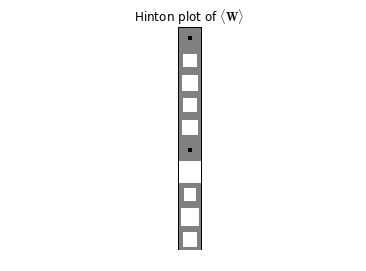

Converged in 13 iterations!


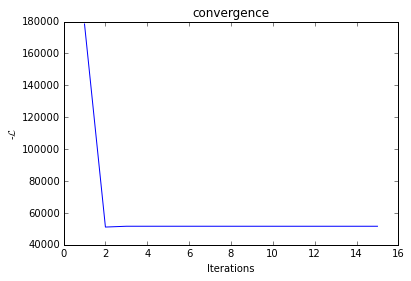

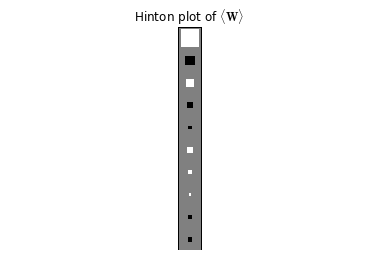

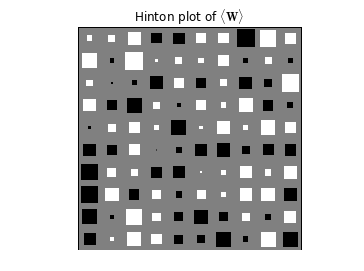

ERROR AT ITERATION 3
(('Non-inveratable sigma_w', array([[  5.43956479e-12,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.15086397e-12,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.76631861e-12,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.15501488e-11,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   5.110422

AssertionError: ('Non-inveratable sigma_w', array([[  5.43956479e-12,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.15086397e-12,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.76631861e-12,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.15501488e-11,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   5.11042211e-11,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.62613668e-12,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.39711110e-12,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.13241414e-12,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.12991612e-12,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.09681502e-12]]), array([ 0.93273598]), array([[[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]],

       [[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]],

       [[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]],

       ..., 
       [[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]],

       [[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]],

       [[ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        ..., 
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077],
        [ 0.09987077,  0.09987077,  0.09987077, ...,  0.09987077,
          0.09987077,  0.09987077]]]), 998.70772681301651)

In [704]:
#generate tha bishop data
N = 100
d=10
#cov = np.tile([5,4,3,2]+[1]*(d-4),(d,1))
cov = np.diag([5,4,3,2]+[1]*(d-4))
mean = [0]*d
print('mean:', mean)
print('cov:', cov)
X = np.random.multivariate_normal(mean, cov, N).T

for q in [1,None]:
    PCA = BayesianPCA(*X.shape, q=q)
    hinton(PCA.means_w.T)
    plt.title(r"Hinton plot of $\langle \mathbf{W} \rangle $")
    plt.show()
    loss_log = PCA.fit(X, debug=True)
    plt.plot(-loss_log)
    #plt.yscale('log')
    plt.title('convergence')
    plt.ylabel('-$\mathcal{L}$')
    plt.xlabel('Iterations')
    plt.show()

    hinton(PCA.means_w.T)
    plt.title(r"Hinton plot of $\langle \mathbf{W} \rangle $")
    #print( PCA.means_w)
    plt.show()

### 7. PCA Representation of MNIST (10 points)

Download the MNIST dataset from here http://deeplearning.net/tutorial/gettingstarted.html (the page contains python code for loading the data). Run your algorithm on (part of) this dataset, and visualize the results.


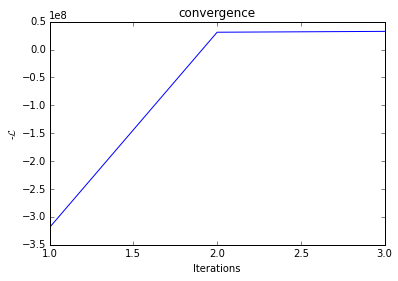

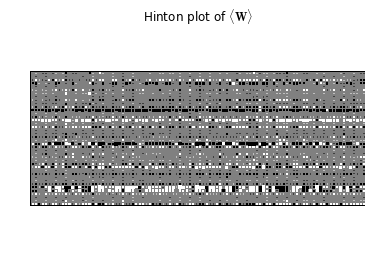

In [692]:
if sys.version_info < (3,):
    try:
        import cPickle as pickle
    except:
        import pickle
    import gzip
    # Load the dataset
    f = gzip.open('mnist.pkl.gz', 'rb')
    train_set, valid_set, test_set = pickle.load(f)
    f.close()
else:
    import _pickle as pickle
    import gzip
    f = gzip.open('mnist.pkl.gz', 'rb')
    train_set, valid_set, test_set = pickle.load(f,encoding='latin1')
    f.close()

X = train_set[0][:100,:]
PCA = BayesianPCA(*X.shape, q=40)
loss_log = PCA.fit(X,max_iter=2)

plt.plot(-loss_log)
plt.title('convergence')
plt.ylabel('-$\mathcal{L}$')
plt.xlabel('Iterations')
plt.show()

hinton(PCA.means_w)
plt.title(r"Hinton plot of $\langle \mathbf{W} \rangle $")
plt.show()

> The hinton plot shows the each $\mw$ as a column. We can see some kind of selection along the d-axis, instead of the q-axis. This indicates that we perhaps swaped dimensions somewhere.

> However, we worked out the expressions in the code very carefully, we wrote all our code using a $q < d$ to prevent dimension errors. For the expectations of which the result was a scalar, we did a double check of the intermediate results.

> We also wrote all sums as matrix operations in our code. We are aware of the fact that this may be prone to mistakes. However, we checked all computations nummerically by implementing them as a for loop and comparing the results. Therefore we are confident that the matrix expressions wil evaluate to what we intended them to.

> We wrote some routines for debugging, but unfortunately we do not have any more time to find our mistake(s). 

> Also, it is quite complicated to debug an algorithm like this. We did quite a few tedious derivations, where we could have made a mathematical mistake. Implementing these complex expressions may also have introduced an error.


> Even tough we did implemented a loss function for sanity checking, deriving this loss function was almost more difficult than deriving the update equations.

> Would we have more time, we would have started by carfully evaluating our expectations. A good starting point for this may be numerical approximation using an integral. (Though this can quickly become infeasable due to the curse of dimensionality). However, using small values for $p$ and $q$ this will reveal most errors (both mathematical and implementational).

> Once we have corrected our expectations the algorithm should work fine. If not, we can investigate our update expressions by again replacing complex matrix operations with simple for loops.